In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Трансформации для CIFAR10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Трансформации для MNIST (преобразование в 3 канала)
transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Загрузка датасетов
trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

trainloader_cifar = DataLoader(trainset_cifar, batch_size=512, shuffle=True)
testloader_cifar = DataLoader(testset_cifar, batch_size=512, shuffle=False)
testloader_mnist = DataLoader(testset_mnist, batch_size=512, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


In [5]:
import shutil
import os
target = '/content/drive/MyDrive/data'
if os.path.exists(target):
    shutil.rmtree(target)
shutil.copytree('./data', target)

'/content/drive/MyDrive/data'

In [6]:
# Модель ResNet18 с dropout для MC Dropout
from torchvision.models import resnet18
from tqdm import tqdm

class ResNetWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.model.fc(x)
        return x

# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    model.train()
    progress_bar = tqdm(trainloader_cifar, desc=f"Epoch {epoch+1}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

# Сохранение модели
torch.save(model.state_dict(), 'resnet_cifar10.pth')

Epoch 3: 100%|██████████| 98/98 [10:15<00:00,  6.28s/it, loss=0.942]


In [7]:
# Сохранение модели на Google Drive
shutil.copy('resnet_cifar10.pth', '/content/drive/MyDrive/resnet_cifar10.pth')

'/content/drive/MyDrive/resnet_cifar10.pth'

In [8]:
# Функция для извлечения фич из penultimate слоя
def get_features(model, data):
    model.eval()
    with torch.no_grad():
        x = model.model.conv1(data)
        x = model.model.bn1(x)
        x = model.model.relu(x)
        x = model.model.maxpool(x)
        x = model.model.layer1(x)
        x = model.model.layer2(x)
        x = model.model.layer3(x)
        x = model.model.layer4(x)
        x = model.model.avgpool(x)
        x = torch.flatten(x, 1)
    return x

# Вычисление порога c для ReAct (90-й перцентиль)
model.load_state_dict(torch.load('resnet_cifar10.pth'))
model.eval()
all_features = []
for inputs, _ in testloader_cifar:
    inputs = inputs.to(device)
    features = get_features(model, inputs)
    all_features.append(features.cpu())
all_features = torch.cat(all_features).view(-1)
c = torch.quantile(all_features, 0.9).item()

In [9]:
# Функции для скоринга
def get_msp_scores(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            softmax = F.softmax(logits, dim=1).max(1)[0]
            scores.append(softmax.cpu())
    return torch.cat(scores).numpy()

def get_mc_dropout_scores(model, loader, T=30):
    scores = []
    for inputs, _ in loader:
        inputs = inputs.to(device)
        batch_scores = []
        model.train()  # Включаем dropout
        with torch.no_grad():  # Добавляем no_grad для экономии памяти
            for _ in range(T):
                logits = model(inputs)
                softmax = F.softmax(logits, dim=1).max(1)[0]
                batch_scores.append(softmax)
        scores.append(torch.stack(batch_scores).mean(0).cpu())
        torch.cuda.empty_cache()  # Очистка памяти после батча
    model.eval()
    return torch.cat(scores).numpy()

def get_react_scores(model, loader, c):
    model.eval()
    scores = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            features = get_features(model, inputs)
            clipped = torch.clamp(features, max=c)
            logits = model.model.fc(clipped)
            score = torch.logsumexp(logits, dim=1)  # Выше для ID
            scores.append(score.cpu())
    return torch.cat(scores).numpy()

In [10]:
# Получение скоров
id_msp = get_msp_scores(model, testloader_cifar)
ood_msp = get_msp_scores(model, testloader_mnist)

id_mc = get_mc_dropout_scores(model, testloader_cifar)
ood_mc = get_mc_dropout_scores(model, testloader_mnist)

id_react = get_react_scores(model, testloader_cifar, c)
ood_react = get_react_scores(model, testloader_mnist, c)

In [11]:
# Вычисление метрик
def compute_metrics(id_scores, ood_scores):
    labels = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
    scores = np.concatenate([id_scores, ood_scores])
    auroc = roc_auc_score(labels, scores)

    # FPR95
    sorted_scores = np.sort(scores[labels == 1])
    thresh = sorted_scores[int(0.05 * len(sorted_scores))]
    fpr95 = np.mean(scores[labels == 0] >= thresh)

    return auroc, fpr95

print("Softmax:")
auroc_msp, fpr95_msp = compute_metrics(id_msp, ood_msp)
print(f"AUROC: {auroc_msp}, FPR95: {fpr95_msp}")

print("MC Dropout:")
auroc_mc, fpr95_mc = compute_metrics(id_mc, ood_mc)
print(f"AUROC: {auroc_mc}, FPR95: {fpr95_mc}")

print("ReAct:")
auroc_react, fpr95_react = compute_metrics(id_react, ood_react)
print(f"AUROC: {auroc_react}, FPR95: {fpr95_react}")

Softmax:
AUROC: 0.68248981, FPR95: 0.8792
MC Dropout:
AUROC: 0.54888909, FPR95: 0.9596
ReAct:
AUROC: 0.50865918, FPR95: 0.9161


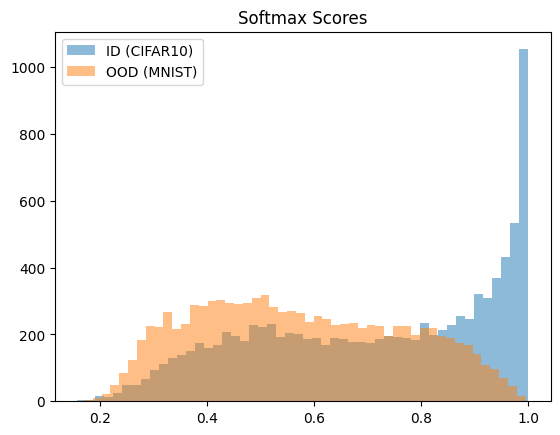

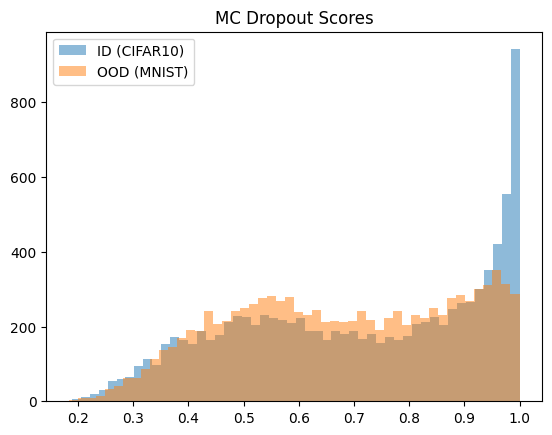

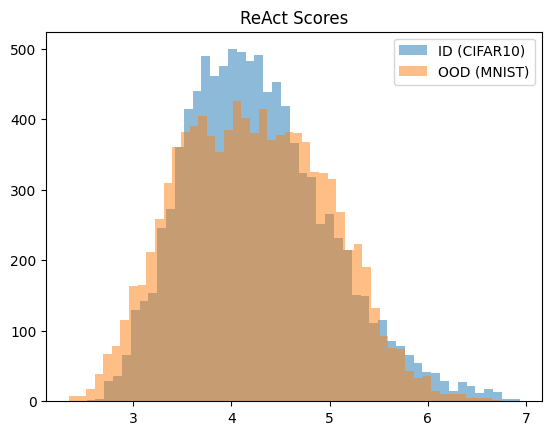

In [12]:
# Графики гистограмм скоров
def plot_hist(id_scores, ood_scores, title):
    plt.figure()
    plt.hist(id_scores, bins=50, alpha=0.5, label='ID (CIFAR10)')
    plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD (MNIST)')
    plt.title(title)
    plt.legend()
    plt.show()

plot_hist(id_msp, ood_msp, 'Softmax Scores')
plot_hist(id_mc, ood_mc, 'MC Dropout Scores')
plot_hist(id_react, ood_react, 'ReAct Scores')